In [1]:
import matplotlib.pyplot as plt
import numpy as np
from argoverse.map_representation.map_api import ArgoverseMap  # 如果需要可视化地图背景
import torch
import pytorch_lightning as pl
import numpy as np
from typing import Callable, Dict, List, Optional, Tuple, Union
from models.hivt import HiVT
from utils import TemporalData
import os 
import random
def plot_single_vehicle(
    avm: ArgoverseMap, 
    sample_past_trajectory: np.ndarray,  # (20, 2)
    sample_groundtruth: np.ndarray,  # (20, 2) 
    sample_forecasted_trajectories: List[np.ndarray],  # List[(30, 2)]
    sample_city_name: str, 
    ls: str):

    # sample_past_trajectory = np.concatenate((np.expand_dims(sample_past_trajectory[-1], axis=0), sample_past_trajectory), axis=0)
    #拼接最后一个点
    sample_groundtruth = np.concatenate((np.expand_dims(sample_past_trajectory[-1], axis=0), sample_groundtruth), axis=0)
    for sample_forecasted_trajectory in sample_forecasted_trajectories:
        sample_forecasted_trajectory = np.concatenate((np.expand_dims(sample_past_trajectory[-1], axis=0), sample_forecasted_trajectory), axis=0)
 
    ## Plot history
    obs_len = sample_past_trajectory.shape[0]
    pred_len = sample_groundtruth.shape[0]

    plt.plot(
        sample_past_trajectory[:, 0],
        sample_past_trajectory[:, 1],
        color="#ECA154",
        label="Past Trajectory",
        alpha=1,
        linewidth=1.5,
        zorder=15,
        ls = '-'
    )

    ## Plot future
    plt.plot(
        sample_groundtruth[:, 0],
        sample_groundtruth[:, 1],
        color="#d33e4c",
        label="Ground Truth",
        alpha=1,
        linewidth=1.5,
        zorder=20,
        ls = "--"
    )

    ## Plot prediction
    for j in range(len(sample_forecasted_trajectories)):
        plt.plot(
            sample_forecasted_trajectories[j][:, 0],
            sample_forecasted_trajectories[j][:, 1],
            color="#007672",
            label="Forecasted Trajectory",
            alpha=1,
            linewidth=1.2,
            zorder=15,
            ls = "--"
        )
        
        # Plot the end marker for forcasted trajectories
        plt.arrow(
            sample_forecasted_trajectories[j][-2, 0], 
            sample_forecasted_trajectories[j][-2, 1],
            sample_forecasted_trajectories[j][-1, 0] - sample_forecasted_trajectories[j][-2, 0],
            sample_forecasted_trajectories[j][-1, 1] - sample_forecasted_trajectories[j][-2, 1],
            color="#007672",
            label="Forecasted Trajectory",
            alpha=1,
            linewidth=2.5,
            zorder=15,
            head_width=1.1,
        )
    
    ## Plot the end marker for history
    plt.arrow(
            sample_past_trajectory[-2, 0], 
            sample_past_trajectory[-2, 1],
            sample_past_trajectory[-1, 0] - sample_past_trajectory[-2, 0],
            sample_past_trajectory[-1, 1] - sample_past_trajectory[-2, 1],
            color="#ECA154",
            label="Past Trajectory",
            alpha=1,
            linewidth=2.5,
            zorder=25,
            head_width=1.0,
        )

    ## Plot the end marker for future
    plt.arrow(
            sample_groundtruth[-2, 0], 
            sample_groundtruth[-2, 1],
            sample_groundtruth[-1, 0] - sample_groundtruth[-2, 0],
            sample_groundtruth[-1, 1] - sample_groundtruth[-2, 1],
            color="#d33e4c",
            label="Ground Truth",
            alpha=1,
            linewidth=2.5,
            zorder=25,
            head_width=1.0,
        )

    ## Plot history context
    for j in range(obs_len):
        lane_ids = avm.get_lane_ids_in_xy_bbox(
            sample_past_trajectory[j, 0],
            sample_past_trajectory[j, 1],
            sample_city_name,
            query_search_range_manhattan=3,
        )
        [avm.draw_lane(lane_id, sample_city_name) for lane_id in lane_ids]

    ## Plot future context
    for j in range(pred_len):
        lane_ids = avm.get_lane_ids_in_xy_bbox(
            sample_groundtruth[j, 0],
            sample_groundtruth[j, 1],
            sample_city_name,
            query_search_range_manhattan=3,
        )
        [avm.draw_lane(lane_id, sample_city_name) for lane_id in lane_ids]

/home/alon/anaconda3/envs/HiVT2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_unit = HiVT.load_from_checkpoint('/home/alon/Learning/HiVT/lightning_logs/version_26/checkpoints/epoch=63-step=659071.ckpt', parallel=True)
_info = model_unit.eval()

In [3]:
am = ArgoverseMap()

送入模型的.pt数据格式与内容 cat


Loaded data from /home/alon/Learning/hivt_data/val/processed/20099.pt
agent_index= 8
av_index= 0
message 
update 


/home/alon/Learning/HiVT/models/local_encoder.py:394: UserWarning: operator() profile_node %28 : int[] = prim::profile_ivalue(%size.4)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  alpha = softmax(alpha, index, ptr, size_i)


predition_unit_batch is called
y_hat_agent.size =  torch.Size([29, 6, 30, 2])


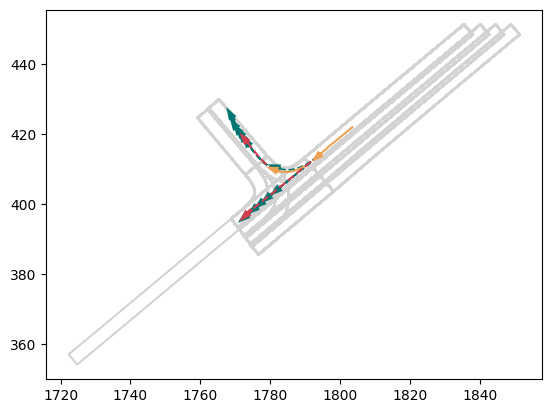

In [4]:
# 设置处理后数据的目录路径

# 循环加载每个 '.pt' 文件 100个随机

# 构造完整的文件路径
file_path = '/home/alon/Learning/hivt_data/val/processed/20099.pt'
# 加载文件内容
test_data = torch.load(file_path)
# 执行所需的操作，例如打印或处理数据
print(f"Loaded data from {file_path}")
print('agent_index=',test_data['agent_index'])
print('av_index=',test_data['av_index'])
with torch.no_grad(): 
    y_hat_agent, pi_agent, seq_id ,position_sce= model_unit.predition_unit_batch(test_data,batch_idx=0)
y_hat_agent = y_hat_agent.permute(0, 1, 2, 3)
print('y_hat_agent.size = ',y_hat_agent.size()) #[29, 6, 30, 2]
# print('pi_agent:',pi_agent)
pred_traj_np = y_hat_agent.cpu().numpy()
full_traj = position_sce
if full_traj.is_cuda:
    full_traj = full_traj.cpu()
# 转换为 NumPy 数组
full_traj_np = full_traj.numpy()

index_agent = test_data['agent_index']
av_agent = test_data['av_index']

actor_to_show = index_agent
sample_past_trajectory = full_traj[actor_to_show,:20,:]
sample_groundtruth = full_traj[actor_to_show,20:,:]
full_truth = full_traj_np[actor_to_show]
sample_forecasted_trajectories = [pred_traj_np[actor_to_show][i] for i in range(pred_traj_np.shape[1])]
#橙色是历史轨迹
#绿色是预测轨迹
#红色是真实轨迹
plot_single_vehicle(am,sample_past_trajectory,sample_groundtruth,sample_forecasted_trajectories,test_data.city,'-.')
actor_to_show = av_agent
sample_past_trajectory = full_traj[actor_to_show,:20,:]
sample_groundtruth = full_traj[actor_to_show,20:,:]
full_truth = full_traj_np[actor_to_show]
sample_forecasted_trajectories = [pred_traj_np[actor_to_show][i] for i in range(pred_traj_np.shape[1])]
plot_single_vehicle(am,sample_past_trajectory,sample_groundtruth,sample_forecasted_trajectories,test_data.city,'-.')
plt.show()
plt.close()
